In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OrdinalEncoder  

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
df= pd.read_csv('twitter_training.csv', names=['Tweet_ID','Topic','Sentiment', 'Tweets'], encoding='ISO-8859-1')

# EDA (Exploratory Data Analysis)

In [39]:
df.sample(10)

,Tweet_ID,Topic,Sentiment,Tweets
39507,5581,Hearthstone,Neutral,Just beat a Demon Hunter with trusty Albo pist...
48536,5932,HomeDepot,Negative,"Please don't come to the depot today, disturb ..."
50323,6239,FIFA,Negative,"I hate constraints, so I stopped playing FIFA ..."
16941,9703,PlayStation5(PS5),Irrelevant,"Thank God. After seeing the X1 tracking, he is..."
35720,8133,Microsoft,Positive,I can't believe we just saw the new console de...
34518,6729,Fortnite,Negative,Why would this fortnite college season be duos...
974,2573,Borderlands,Negative,That cricket was the worst fennel fennel I've ...
39670,1210,Battlefield,Negative,NaN
40045,1274,Battlefield,Irrelevant,A ban has been imposed on Battlefield 4 player...
46997,5663,HomeDepot,Negative,Bro why Home Depot got a fucking line like the...


In [40]:
df.shape

(74682, 4)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Tweets     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [42]:
df.isna().sum()

Tweet_ID       0
Topic          0
Sentiment      0
Tweets       686
dtype: int64

In [43]:
df['Topic'].value_counts()

Topic
TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)         

In [44]:
df[df['Topic']== 'Nvidia'].sample(5)

,Tweet_ID,Topic,Sentiment,Tweets
72767,8865,Nvidia,Positive,Shiny local computer memory dev kit. Interesti...
73185,8937,Nvidia,Neutral,NVIDIA Stock Falls 3% at invst.ly/r3k3b
73143,8930,Nvidia,Neutral,Cisco and NVIDIA Partner to Deliver a Premium ...
73756,9035,Nvidia,Neutral,Watch about part 4 of the
73513,8992,Nvidia,Negative,Like his so delayed Bro I missed GOD CLIPS Fnc...


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Tweets     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [46]:
df['Sentiment'].value_counts()

Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7adfcc2b1630>,
 [Text(0.6414093669225578, 0.8936408809046303, 'Negative'),
  Text(-1.0260553442286633, 0.39649770564254155, 'Positive'),
  Text(-0.31734499213929374, -1.0532293937999033, 'Neutral'),
  Text(0.9398173765782871, -0.5716146417662045, 'Irrelavant')],
 [Text(0.3498596546850315, 0.4874404804934347, '30.2'),
  Text(-0.5596665513974526, 0.21627147580502265, '27.9'),
  Text(-0.17309726843961473, -0.5744887602544927, '24.5'),
  Text(0.5126276599517929, -0.31178980459974787, '17.4')])

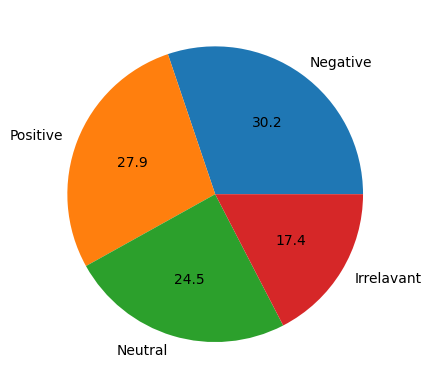

In [47]:
plt.pie(df['Sentiment'].value_counts(), labels=['Negative','Positive','Neutral','Irrelavant'],autopct='%0.1f')

In [48]:
# from ydata_profiling import ProfileReport
# eda=ProfileReport(df)
# eda.to_file(output_file='EDA_Report.html')

# Cleaning Data

In [49]:
df= df.drop(columns=['Tweet_ID'], axis=1)

In [50]:
df.shape

(74682, 3)

In [51]:
df= df.dropna(subset=['Tweets'])

In [52]:
df.shape

(73996, 3)

In [53]:
74682-73996

686

In [54]:
df.duplicated().value_counts()

False    70958
True      3038
Name: count, dtype: int64

In [55]:
df= df.drop_duplicates(keep='first')

In [56]:
df.shape

(70958, 3)

In [57]:
73996-70958 

3038

# Processing Tweets using the nltk module

In [58]:
import nltk
from nltk.stem import SnowballStemmer 
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer


In [59]:
tw= df['Tweets'].sample().values[0]
tw

'at Yo we live!. . 9 hour GTA stream, stealing cars for now and heisting later when the whole gang is on.... .  . . [twitch.tv/124tv]. [twitch.tv/124tv]. [twitch.tv/124tv] RhttpR]'

In [60]:
tb=TreebankWordTokenizer()
tb.tokenize(tw)

['at',
 'Yo',
 'we',
 'live',
 '!',
 '.',
 '.',
 '9',
 'hour',
 'GTA',
 'stream',
 ',',
 'stealing',
 'cars',
 'for',
 'now',
 'and',
 'heisting',
 'later',
 'when',
 'the',
 'whole',
 'gang',
 'is',
 'on',
 '...',
 '.',
 '.',
 '.',
 '.',
 '[',
 'twitch.tv/124tv',
 ']',
 '.',
 '[',
 'twitch.tv/124tv',
 ']',
 '.',
 '[',
 'twitch.tv/124tv',
 ']',
 'RhttpR',
 ']']

In [61]:
#creating columns to store the number of characters, words and sentences

df['characters']= df['Tweets'].apply(len)
df['words']= df['Tweets'].apply(lambda x: len(tb.tokenize(x)))
df['sentences']= df['Tweets'].apply(lambda x: len(sent_tokenize(x)))  

In [62]:
df

,Topic,Sentiment,Tweets,characters,words,sentences
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11,1
1,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13,1
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11,1
3,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11,1
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13,1
...,...,...,...,...,...,...
74677,Nvidia,Positive,Just realized that the Windows partition of my...,128,26,1
74678,Nvidia,Positive,Just realized that my Mac window partition is ...,117,24,1
74679,Nvidia,Positive,Just realized the windows partition of my Mac ...,127,25,1
74680,Nvidia,Positive,Just realized between the windows partition of...,161,32,1


In [63]:
df[['characters', 'words', 'sentences']].describe()

,characters,words,sentences
count,70958.000000,70958.000000,70958.000000
mean,111.614025,22.354449,1.963232
std,79.490808,16.528309,1.639051
min,1.000000,0.000000,0.000000
25%,50.000000,10.000000,1.000000
50%,94.000000,18.000000,1.000000
75%,156.000000,31.000000,2.000000
max,957.000000,198.000000,33.000000


In [64]:
df['sentences'].unique()

array([ 1,  8,  4,  2,  6,  5,  3, 10,  7, 12, 13, 11,  9, 14,  0, 15, 16,
       18, 21, 20, 25, 17, 19, 22, 31, 33, 23, 24, 28])

In [65]:
print(df[df['sentences'] == 33]['Tweets'].values[0])

Today is  . . . No Amazon. . . No Walmart. . . No DoorDash. . . No Instacart. . . No Whole Foods. . . No Target. . . No GrubHub. . . No McDonalds. . . No Home Depot. . . No Bojangles. . For today, stand in solidarity with frontline workers and do your shopping another day.  


In [66]:
df['Sentiment'].value_counts().index

Index(['Negative', 'Positive', 'Neutral', 'Irrelevant'], dtype='object', name='Sentiment')

In [67]:
for i in (df['Sentiment'].value_counts().index):    
    print('Table for',i)
    print(df[df['Sentiment'] == i][['characters','words','sentences']].describe())
    print()

Table for Negative
         characters         words     sentences
count  21565.000000  21565.000000  21565.000000
mean     114.280223     23.022583      1.835845
std       81.909385     16.699111      1.372155
min        1.000000      0.000000      0.000000
25%       48.000000     10.000000      1.000000
50%       95.000000     19.000000      1.000000
75%      164.000000     33.000000      2.000000
max      727.000000    198.000000     22.000000

Table for Positive
         characters         words     sentences
count  19549.000000  19549.000000  19549.000000
mean      99.160980     20.227275      1.917796
std       77.498124     16.251101      1.601854
min        1.000000      0.000000      0.000000
25%       40.000000      8.000000      1.000000
50%       78.000000     16.000000      1.000000
75%      138.000000     28.000000      2.000000
max      692.000000    198.000000     33.000000

Table for Neutral
         characters         words     sentences
count  17398.000000  17398.000

# EDA(again)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

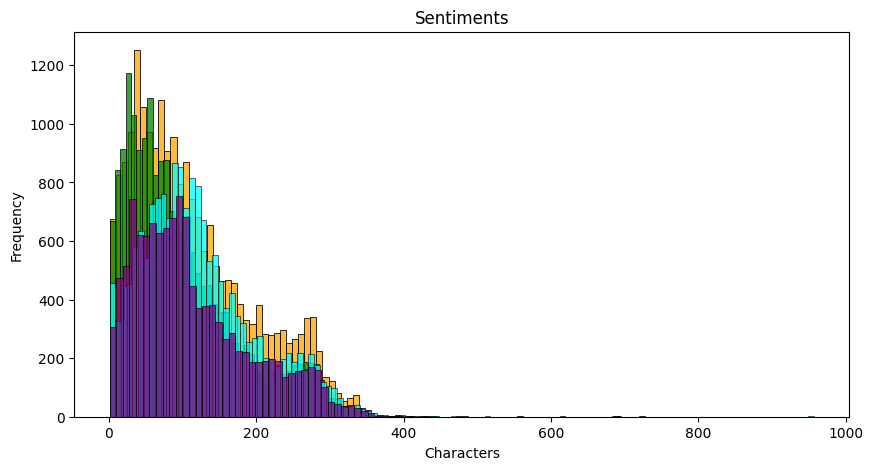

In [68]:
color_map = {
    'Positive': 'green',
    'Negative': 'orange',
    'Neutral': 'cyan',
    'Irrelevant': 'purple'
}

plt.figure(figsize=(10,5))
plt.title('Sentiments')
plt.xlabel('Characters')
plt.ylabel('Frequency')
for SENTIMENT in (df['Sentiment'].value_counts().index): 
    COLOR=color_map.get(SENTIMENT, 'gray') # get(key, default value)
    sns.histplot(df[df['Sentiment']== SENTIMENT]['characters'], color=COLOR)
plt.show()

   # Data Processing

-> lower cases 
-> Tokenization
-> Removing special Charaecter
-> Removing stop words and punctuation
-> Stemming


In [69]:
#we fiurst renove the lower cases using tweet.lower() then we'll tokenize the tweet into words so as to remove any toekens which are english stopwords or are punctuations
import string
ss=SnowballStemmer(language='english') 

In [70]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [71]:
def transformed_tweet(tweet):
    
    temp_tweet=[]
    
    tweet=tweet.lower()
    tweet=tb.tokenize(tweet)
    for i in tweet:
        if i.isalnum() and i not in stopwords.words('english') and i not in string.punctuation:
            temp_tweet.append(ss.stem(i))
    
    return " ".join(temp_tweet) #uses the join function to join the elements in the list into a string
            

In [72]:
df['transformed_tweet']= df['Tweets'].apply(lambda x: transformed_tweet(x))

In [73]:
df

,Topic,Sentiment,Tweets,characters,words,sentences,transformed_tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,53,11,1,im get borderland murder
1,Borderlands,Positive,I am coming to the borders and I will kill you...,51,13,1,come border kill
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,50,11,1,im get borderland kill
3,Borderlands,Positive,im coming on borderlands and i will murder you...,51,11,1,im come borderland murder
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57,13,1,im get borderland 2 murder
...,...,...,...,...,...,...,...
74677,Nvidia,Positive,Just realized that the Windows partition of my...,128,26,1,realiz window partit mac like 6 year behind nv...
74678,Nvidia,Positive,Just realized that my Mac window partition is ...,117,24,1,realiz mac window partit 6 year behind nvidia ...
74679,Nvidia,Positive,Just realized the windows partition of my Mac ...,127,25,1,realiz window partit mac 6 year behind nvidia ...
74680,Nvidia,Positive,Just realized between the windows partition of...,161,32,1,realiz window partit mac like 6 year behind nv...


In [74]:
df[df['Sentiment']== 'Positive']['transformed_tweet'].shape

(19549,)

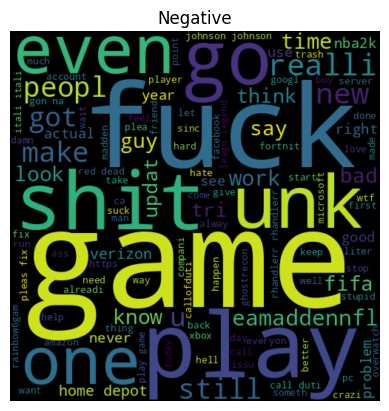

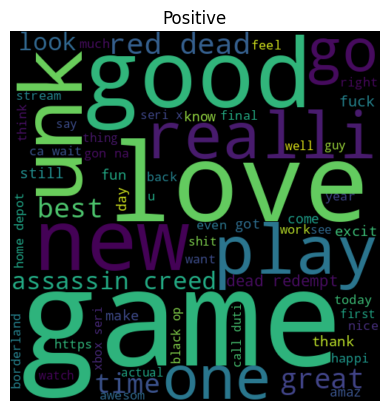

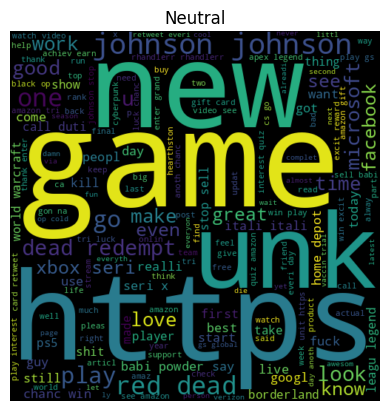

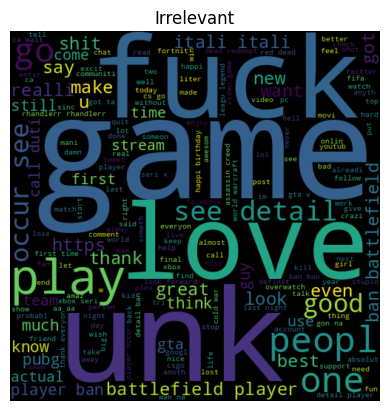

In [75]:
from wordcloud import WordCloud
wc=WordCloud(min_font_size=10, width=500, height=500)

for SENTIMENT in df['Sentiment'].value_counts().index:
    plt.figure()
    show_wc= wc.generate(df[df['Sentiment']== SENTIMENT]['transformed_tweet'].str.cat(sep= " "))
    plt.title(SENTIMENT)
    plt.imshow(show_wc,  interpolation='bilinear')
    plt.axis("off") 
    plt.show() # helps top show all 4 word clouds since jupyternotebook only shows the last executed code

# Enncoding and making Pipeline

In [93]:
oe=OrdinalEncoder(categories=[['Negative','Positive','Neutral','Irrelavant']])
df['Sentiment']= oe.fit_transform(df['Sentiment'])

ValueError: Expected 2D array, got 1D array instead:
array=[3 3 3 ... 3 3 3].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [90]:
df['Sentiment'].value_counts()

Sentiment
1    21565
3    19549
2    17398
0    12446
Name: count, dtype: int64

In [89]:
df.sample(2)

,Topic,Sentiment,Tweets,characters,words,sentences,transformed_tweet
41519,Battlefield,0,second ban against Battlefield 1 with arkaadZ ...,100,14,1,second ban battlefield 1 arkaadz occur see detail
58146,TomClancysRainbowSix,1,fuck,4,1,1,fuck
